In [1]:
%load_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%aimport SweetSpotPrediction
import SweetSpotPrediction as ssp

# 01 Data Preperation
Here we can convert the raw data into our features and labels.

*Paths*
* Classification: Simple datatable for each (X,Y) Pos
<table>
    <thead><tr><td>X pos</td><td>Y pos</td><td>value_map_1</td><td>value_map_2</td><td>value_map_3</td><td>A_well_was_drilled_at_this_pos</td></tr></thead>
    <tr><td>0</td><td>0</td><td>5.2</td><td>1.2</td><td>1.2</td><td>False</td></tr>
    <tr><td>0</td><td>1</td><td>6.3</td><td>6.3</td><td>6.3</td><td>True</td></tr>
    </table>
* Regression: Simple datatable for each (X,Y) Pos. Distance factor (0.0-1.0) should probably be a quadratic factor?
<table>
    <thead><tr><td>X pos</td><td>Y pos</td><td>value_map_1</td><td>value_map_2</td><td>value_map_3</td><td>Distance_factor_from_actual_well</td></tr></thead>
    <tr><td>0</td><td>0</td><td>5.2</td><td>1.2</td><td>1.2</td><td>0.62</td></tr>
    <tr><td>0</td><td>1</td><td>6.3</td><td>6.3</td><td>6.3</td><td>1.0</td></tr>
    </table>
* Deep Learning (**Out of scope**): Combine the 2D maps into a single feature space and as a lable a 2D mask with actual production well location (perfect for convolutional neural networks)

# Read Maps, including Well Probability

In [2]:
# File paths with corresponding map names
files_names = {'Data\\thickness\\thickness': 'Thickness'
         , 'Data\\avgntg\\avgntgasc': 'AvgNTG'
         , 'Data\\avgperm\\avgpermasc': 'AvgPerm'
         , 'Data\\avgporo\\avgporoasc': 'AvgPoro'
         , 'Data\\netperm\\netpermasc': 'NetPerm'
         , 'Data\\distwellweight.txt': 'WellProbability'
         , 'Data\\sweetspot.txt': 'SweetSpot'
              }

# Read map files
dfs = []
spacing = 50 # map grid cell dimension
for key in files_names:
    df = pd.read_csv(key, delimiter=' ', comment='#', names=['XPos', 'YPos', files_names[key], 'c1', 'c2'])
    df.drop(columns=['c1', 'c2'], inplace=True)
    df_reg = ssp.make_regular(df, files_names[key], spacing)
    df_reg.set_index(['XPos','YPos'], inplace=True)
    dfs = dfs + [df_reg]

# Merge dataframes
df = pd.concat(dfs, axis='columns', join='inner').reset_index()

In [3]:
df.describe()

,XPos,YPos,Thickness,AvgNTG,AvgPerm,AvgPoro,NetPerm,WellProbability,SweetSpot
count,22440.000000,2.244000e+04,20196.000000,15948.000000,16581.000000,16581.000000,15242.000000,16581.000000,1.325100e+04
mean,455375.000000,6.784700e+06,47.635103,0.421225,268.979913,0.148832,5151.761560,0.081332,1.584908e-01
std,1962.981588,2.381579e+03,72.790268,0.585321,480.604983,0.065639,5904.965672,0.076327,3.558815e-01
min,452000.000000,6.780600e+06,-99.220518,-2.716985,-1926.305467,-0.256188,-19704.935208,0.015201,-9.484295e-01
25%,453687.500000,6.782650e+06,-12.841424,0.428203,95.082471,0.123295,1173.427178,0.035907,-4.239839e-05
50%,455375.000000,6.784700e+06,34.878185,0.601743,156.600477,0.142840,3424.826356,0.058447,9.564236e-08
75%,457062.500000,6.786750e+06,104.958917,0.702460,286.990163,0.163693,7742.928171,0.095726,1.375954e-02
max,458750.000000,6.788800e+06,214.915896,2.565845,3676.099741,0.801105,38487.214756,0.795190,1.324121e+00


# Add Well locations (Classification)

In [4]:
# Get well locations
file = 'Data\\welltops.txt'

wells = pd.read_csv(file, delimiter='\t', index_col=0, usecols=[0, 2, 3])

In [5]:
# Create well_presence series, assigning 1 to nearest index to each well, add to df
well_presence = [0]*df.shape[0]
for lab,row in wells.iterrows():
    xw = row['X']
    yw = row['Y']
    distsq = (df.XPos - xw)**2 + (df.YPos - yw)**2
    well_presence[distsq.idxmin()] = 1
    
df['WellPresent'] = well_presence

In [6]:
df.head()

,XPos,YPos,Thickness,AvgNTG,AvgPerm,AvgPoro,NetPerm,WellProbability,SweetSpot,WellPresent
0,452000.0,6780600.0,-19.843674,NaN,NaN,NaN,NaN,NaN,NaN,0
1,452000.0,6780650.0,-17.164212,NaN,NaN,NaN,NaN,NaN,NaN,0
2,452000.0,6780700.0,-14.827628,NaN,NaN,NaN,NaN,NaN,NaN,0
3,452000.0,6780750.0,-14.540321,NaN,NaN,NaN,NaN,NaN,NaN,0
4,452000.0,6780800.0,-15.951475,NaN,NaN,NaN,NaN,NaN,NaN,0


In [7]:
df.dtypes

XPos               float64
YPos               float64
Thickness          float64
AvgNTG             float64
AvgPerm            float64
AvgPoro            float64
NetPerm            float64
WellProbability    float64
SweetSpot          float64
WellPresent          int64
dtype: object

#  Feature engineering

In [8]:
# df['PermTimesPoro'] = np.sqrt(df['AvgPerm'] / df['AvgPoro'])

In [9]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro',
    'NetPerm',
    
    # Engineered
#    'PermTimesPoro'

]

label_clf = 'WellPresent' 
label_reg = 'WellProbability'
lable_swt = 'SweetSpot'

# Goal: Sweet Spots 

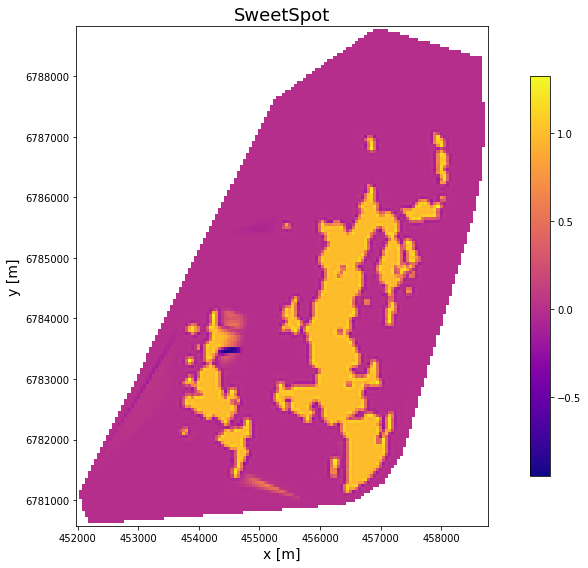

In [10]:
ssp.plot_map(df, 'SweetSpot', dtype='cat')

# Data cleaning

In [11]:
# Functions to drop values less than zero or greater than one

def drop_neg(x):
    if x < 0:
        return np.nan
    else:
        return x

def drop_gt1(x):
    if x > 1:
        return np.nan
    else:
        return x
    
def zero_to_one(x):
    if x < 0.2:
        return 0
    else:
        return 1

In [12]:
def clean_columns(df):

    # Clean dataframe according to specified columns to remove negatives or greater than one
    df_clean = df.copy()

    cols_remove_negs = set(df_clean.columns) - {'XPos', 'YPos', 'SweetSpot'}
    cols_remove_gt1 = {'AvgNTG', 'WellProbability'}
    cols_limit_zero_to_one = { 'SweetSpot'}


    for col in df_clean.columns:
        if col in cols_remove_negs:
            df_clean[col] = df_clean[col].apply(drop_neg)
        if col in cols_remove_gt1:
            df_clean[col] = df_clean[col].apply(drop_gt1)
        if col in cols_limit_zero_to_one:
            df_clean[col] = df_clean[col].apply(zero_to_one)
    df_clean.dropna(inplace=True)
    return df_clean

In [13]:
# Clean dataframe according to specified columns to remove negatives or greater than one

df_clean = clean_columns(df)
df_clean.SweetSpot = df_clean.SweetSpot.fillna(0).round().astype('int64')

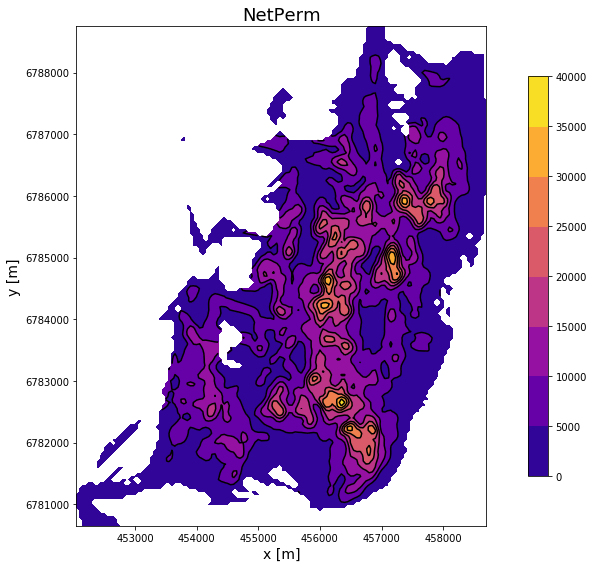

In [14]:
# QC plot cleaned maps

plot = 'NetPerm'
ssp.plot_map(df_clean, plot, dtype='numeric')

# Correlations

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


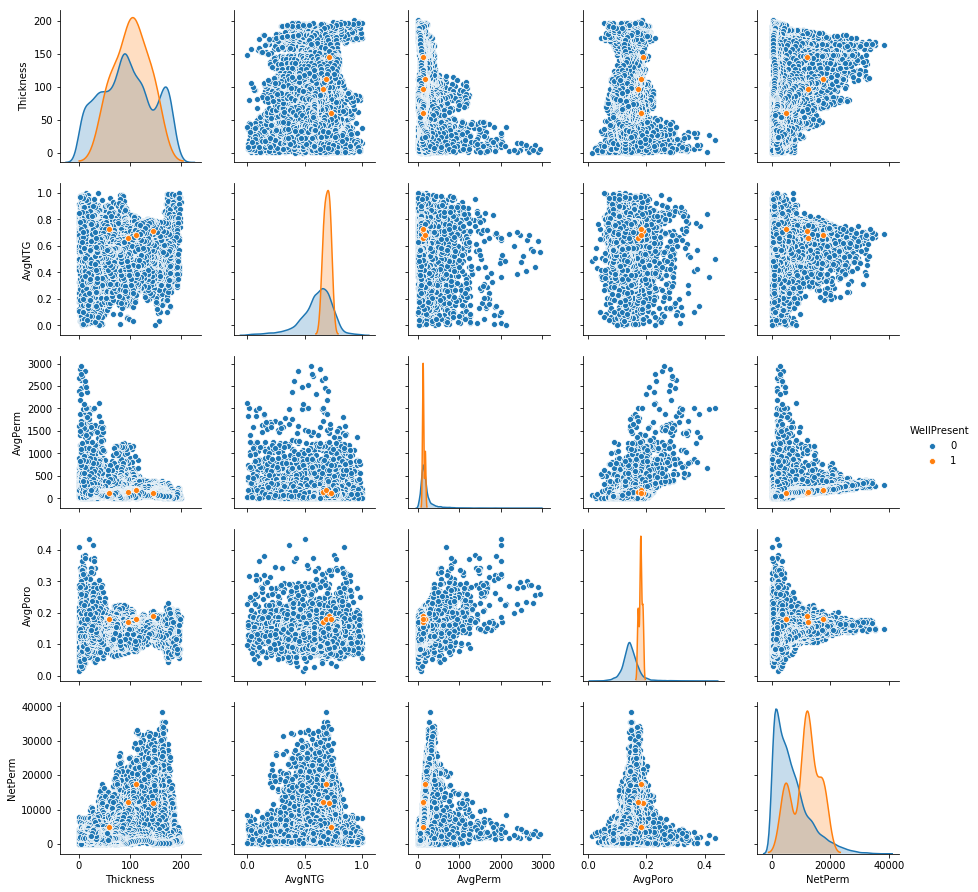

In [15]:
sns.pairplot(df_clean, vars=features, hue='WellPresent' )

# Save the data

In [16]:
df_cls = df_clean.drop(columns='WellProbability')
df_rgs = df_clean.drop(columns='WellPresent')

df_cls.to_csv('ClassificationData.csv')
df_rgs.to_csv('RegressionData.csv')

# Copy paste features and Labels

# TODO
* Discuss Train/Validation/Test split (arbitrary random or specific say reserving a few wells for each set)??

# <a href="02 Base Model.ipynb">Next</a> Notebook